In [2]:
packages <- c("survRM2", "mvtnorm", "ggplot2", "MASS", "tidyr", "survival", "nph",
              "foreach", "doParallel", "cowplot", "IRdisplay", "rlang","tidyverse")

install_and_load <- function(package) {
  if (!require(package, character.only = TRUE)) {
    install.packages(package)
    library(package, character.only = TRUE)
  }
}

invisible(lapply(packages, install_and_load))

n_cores <- detectCores()
cluster <- makeCluster(16)  
registerDoParallel(cluster)
# multi thread
invisible(clusterEvalQ(cluster, #import packages to parallel 
  {
  library('survRM2')
  library('mvtnorm')
  library('cubature')
  library('survival')
  library('nph')
  library("simtrial")
  library("foreach")
  }))

source('Rfiles/3m_comparison.R')
source('Rfiles/Function.R')
clusterExport(cluster, "expo_gen_2stages")

# 3 Methods Comparison Under Proportional Hazard

### 2 stages Rejection region of overall:
### 1. Log rank test
#### $\textcolor{lightgreen}{\frac{W_1}{\sigma_1}>m_1\ \&\ \frac{W}{\sigma}>m_2}$
### 2. Simple RMST Difference
#### $ \textcolor{lightgreen}{E(\tau_1) - C(\tau_1) > m_1\ \&\  E(\tau_2)-C(\tau_2)>m_2 }$
### 3. Our RMST Rejection method
#### $ \textcolor{lightgreen}{E(\tau_1)-C(\tau_1)>m_1\ \&\  E(\tau_1)>t_1\ \&\  E(\tau_2)-C(\tau_2)>m_2\ \&\  E(\tau_2)>t_2}$
--------

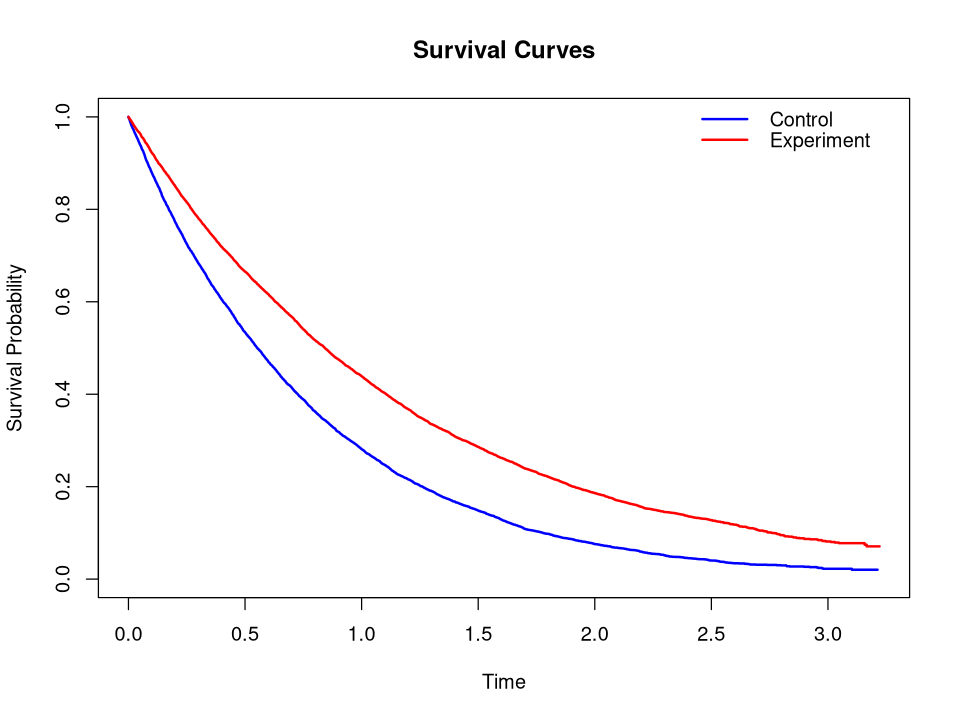

In [4]:
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
lambda_H0 <- 0.83 * 1.5
alpha <- 0.05

set.seed(2024)
data_C <- expo_gen_2stages(N = 10000, acc_time = acc_time, lambda = lambda_H0, 
                           dist = 'exp', cen_time = cen_time, arm = 0, interim = interim)[ , c(4,5,1)]
data_E <- expo_gen_2stages(N = 10000 ,acc_time = acc_time, lambda = lambda_H1, 
                           dist = 'exp', cen_time = cen_time, arm = 1, interim = interim)[ , c(4,5,1)]
pre_data <- rbind(data_C,data_E)
fit <- survfit(Surv(pre_data[,1], pre_data[,2]) ~ pre_data[,3])
options(repr.plot.width = 8, repr.plot.height = 6)
plot(fit, col = c("blue", "red"), lwd = 2, xlab = "Time", ylab = "Survival Probability", main = "Survival Curves")
legend("topright", legend = c("Control", "Experiment"), col = c("blue", "red"), lwd = 2, bty = "n")

# Differnent scenario 
#### Remarks: function 3m_comparison contains cocurrent foreach loop. 
## In this project: HR = $\textcolor{lightgreen}{\frac{\lambda_E}{\lambda_C}}$

---
## 1.  Different Hazard Ratio
#### $\lambda_{E|H1} = 0.83 = log(2)*12/10$. ( Median event time is around 10 months )
#### In this case, $H_0, H_1$ both change. Fix $\lambda_{E|H1}$
#### $H0: \lambda_E = \lambda_C = \frac{\lambda_{E|H1}}{HR}$
#### $H1: \lambda_E = \lambda_{E|H1},\ \lambda_C =  \frac{\lambda_{E|H1}}{HR}$

In [5]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
alpha <- 0.05

diff_hr <- data.frame()
for (HR in seq(0.4, 0.9, by = 0.05))
    {
    lambda_H0 <- lambda_H1 / HR
    result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
    diff_hr <- rbind(diff_hr,c(HR, result$alpha, result$power, result$PET0, result$PET1))
    }


# diff_hr <- foreach(HR = seq(0.4, 0.9, by = 0.05), .combine = rbind) %do%
#     {
#         lambda_H0 <- lambda_H1 / HR
#         result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
#                 interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)        
#         c(HR, result$alpha, result$power, result$PET0, result$PET1)      
#     }

In [4]:
diff_hr

PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>
0.4400,0.0000,0.0182,1.0000
0.8102,0.0022,0.0000,0.9932
0.9886,0.0146,0.0000,0.9694
0.4418,0.0000,0.0296,1.0000
0.6140,0.0022,0.0008,0.9934
0.9520,0.0118,0.0000,0.9756
0.2234,0.0010,0.0468,0.9972
0.5626,0.0072,0.0014,0.9812
0.8986,0.0160,0.0000,0.9642


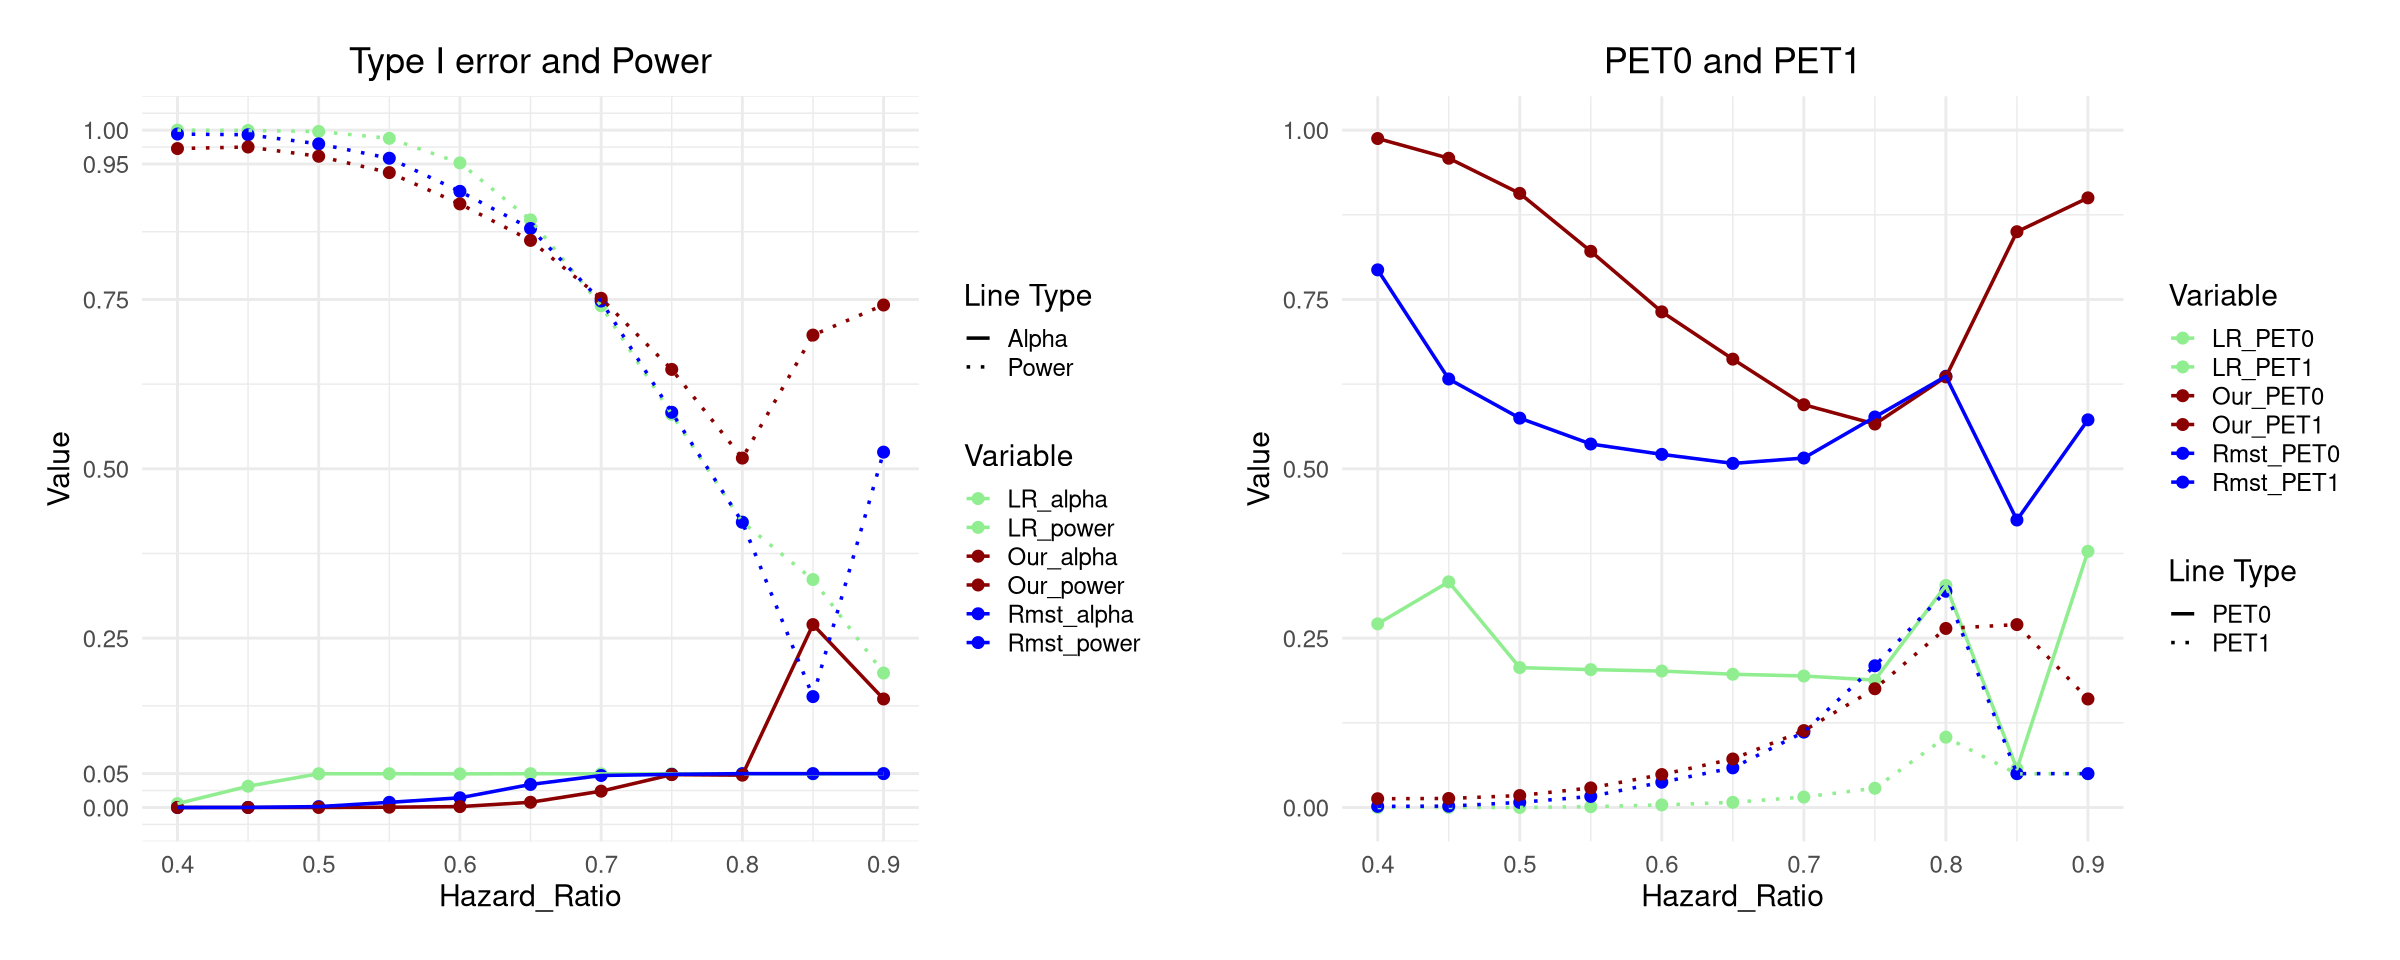

In [12]:
#save(diff_hr, file = '/home/r27user6/RMST_Code/RData/diff_hr.RData')
#load('/home/r27user6/RMST_Code/RData/diff_hr.RData')
# self-define function for drawing plots
p1 <- compare_line_plot(data = diff_hr, var_name = 'Hazard_Ratio')
p1

In [3]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
interim <- 120 / r
lambda_H1 <- 0.83
alpha <- 0.05
HR <- 0.9
lambda_H0 <- lambda_H1 / HR
 
data_C <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 0, interim = interim)    
data_E_H0 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H0, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim) 

data_E_H1 <- expo_gen_2stages(N = n * sim_size, acc_time = acc_time, lambda = lambda_H1, dist = 'exp', 
                            cen_time = cen_time, arm = 1, interim = interim)
rmst_h0_int <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h1_int <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(2,3,1)], 
                                data_C = data_C[ , c(2,3,1)],tau = interim, sim_size = sim_size)
rmst_h0_fin <- RMST_sim_cal(n = n,data_E = data_E_H0[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = acc_time + cen_time,sim_size = sim_size)
rmst_h1_fin <- RMST_sim_cal(n = n,data_E = data_E_H1[ , c(4,5,1)], 
                                data_C = data_C[ , c(4,5,1)],tau = acc_time + cen_time,sim_size = sim_size)
rmst_data <- rbind(rmst_h0_int, rmst_h1_int, rmst_h0_fin, rmst_h1_fin)
mu_cov_h0 <- mu_cov_mc(rmst_int = rmst_h0_int, rmst_fin = rmst_h0_fin, sim_size = sim_size)
mu_cov_h1 <- mu_cov_mc(rmst_int = rmst_h1_int, rmst_fin = rmst_h1_fin, sim_size = sim_size)

best_our <- adp_grid_src(rmst_data = rmst_data, mu_cov_h0 = mu_cov_h0, mu_cov_h1 = mu_cov_h1, 
                int_n = interim * r, fin_n = 2 * n, alpha = alpha, sim_size = sim_size, type = 'Complex')
                

In [8]:
best_our

m1,t1,m2,t2,lambda,gamma,PET0,PET1,alpha,power
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.002155854,0.7665212,0.1013649,1.111998,0.71,0.79,0.7338,0.5674,0.05,0.2059


------
## 2. Different $\lambda_{E|H1}$
#### Different from changing hazard ratio.
#### In this case, Fix $H_0: \lambda_E = \lambda_C = 0.83 / 0.67 = 1.25$ 
#### $H_1$ is changing: $\lambda_C = 0.83 / 0.67 = 1.25,\ \lambda_E = \lambda_{E|H1}$

In [3]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90
acc_time <- 200 / r
interim <- 120 / r
cen_time <- 1
delta <- 1.5
lambda_H0 <- 0.83 * 1.5
alpha <- 0.05

diff_lamb_e <- foreach(lambda_H1 = seq(0.7, 1.2, by = 0.05), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(lambda_H1, result$alpha, result$power, result$PET0, result$PET1)        
    }

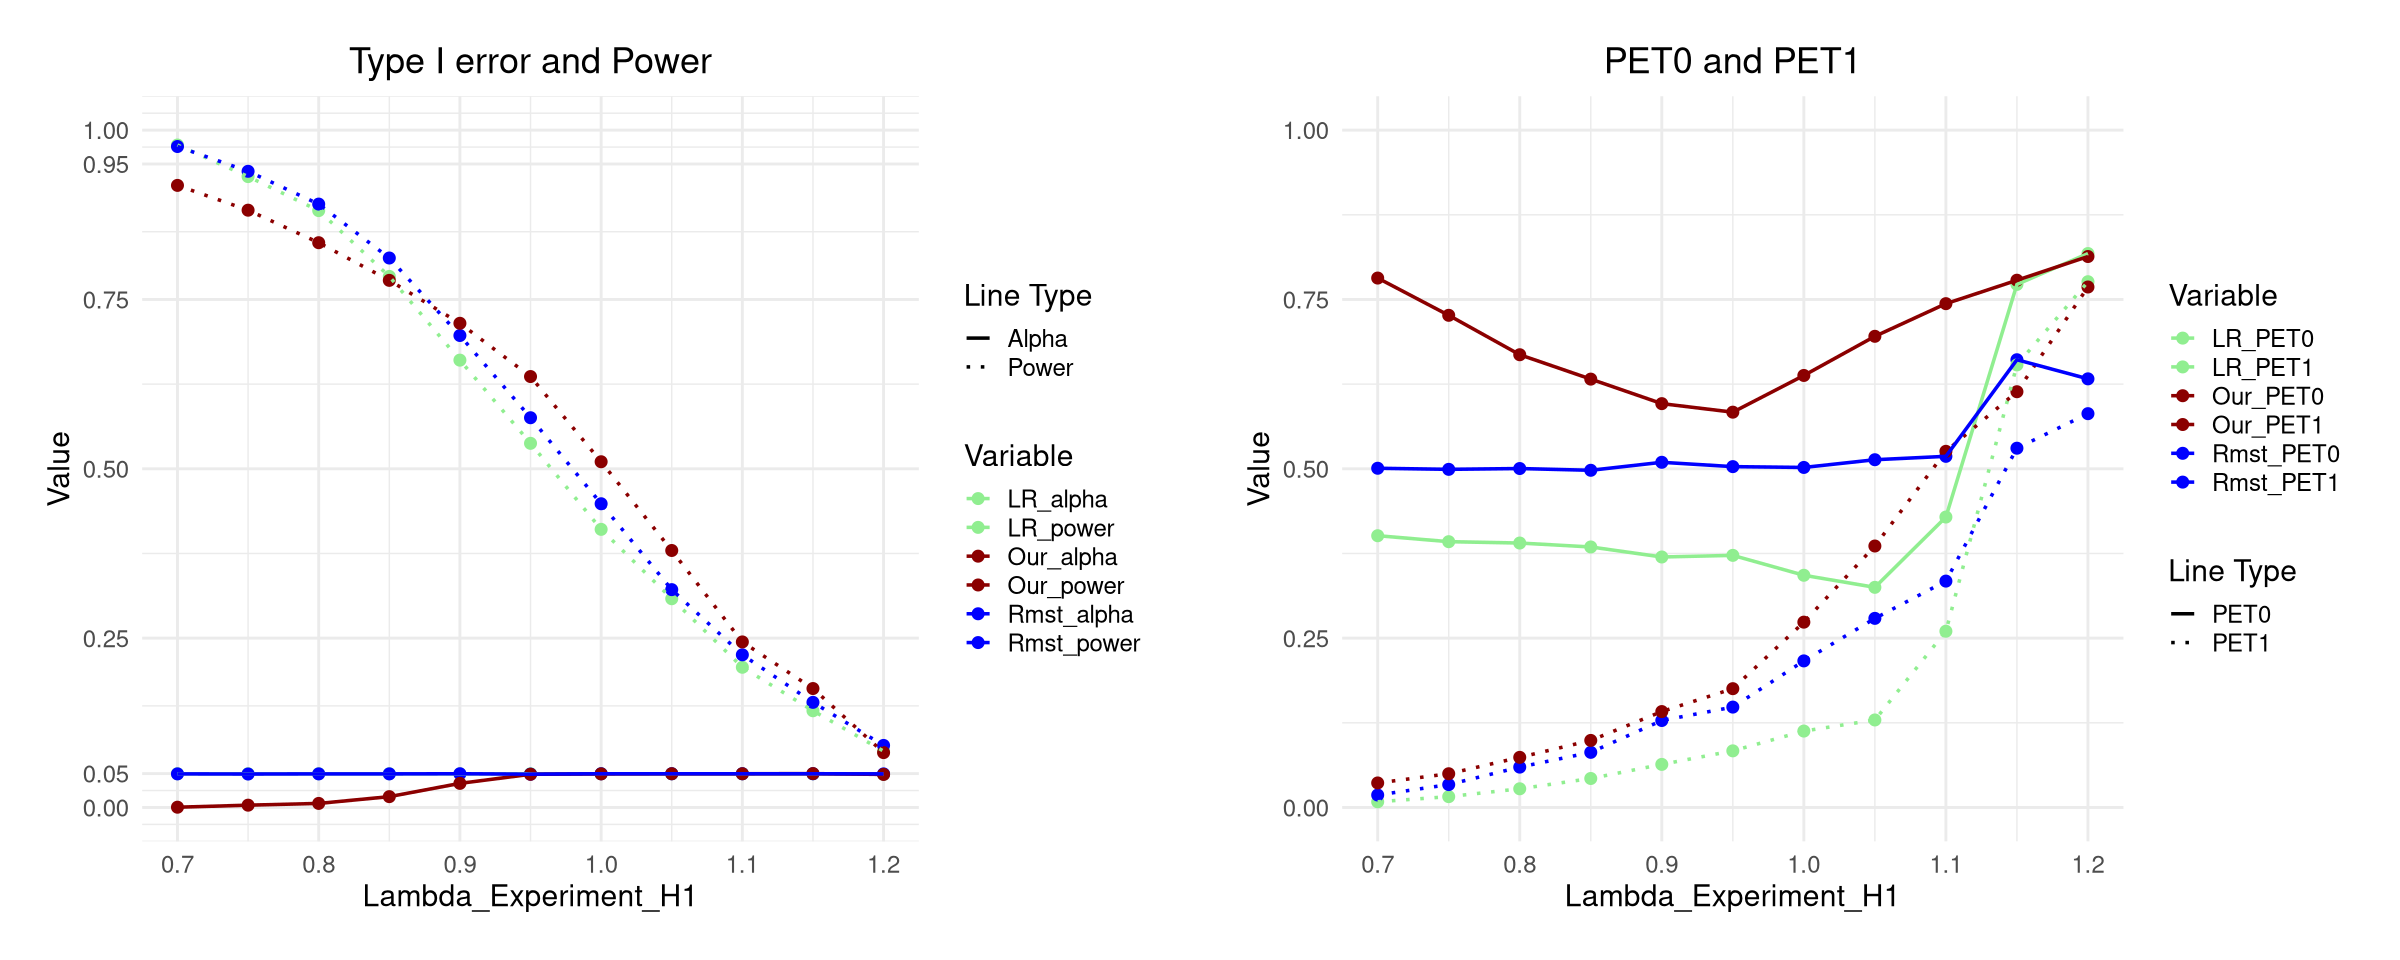

In [25]:
#save(diff_lamb_e, file = '/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')
load('/home/r27user6/RMST_Code/RData/diff_lamb_e.RData')

p2 <- compare_line_plot(data = diff_lamb_e, var_name = 'Lambda_Experiment_H1')
p2

-----
## 3. Different interim period
### Interim period from 40% to 90% of the whole accrual period

In [29]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90  # patient recruit rate
acc_time <- 200 / r
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
alpha <- 0.05

diff_interim <- foreach(int_sam = seq(80, 180, by = 10), .combine = rbind) %do%
    {
        interim <- int_sam / r
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(interim, result$alpha, result$power, result$PET0, result$PET1)  
      
    }

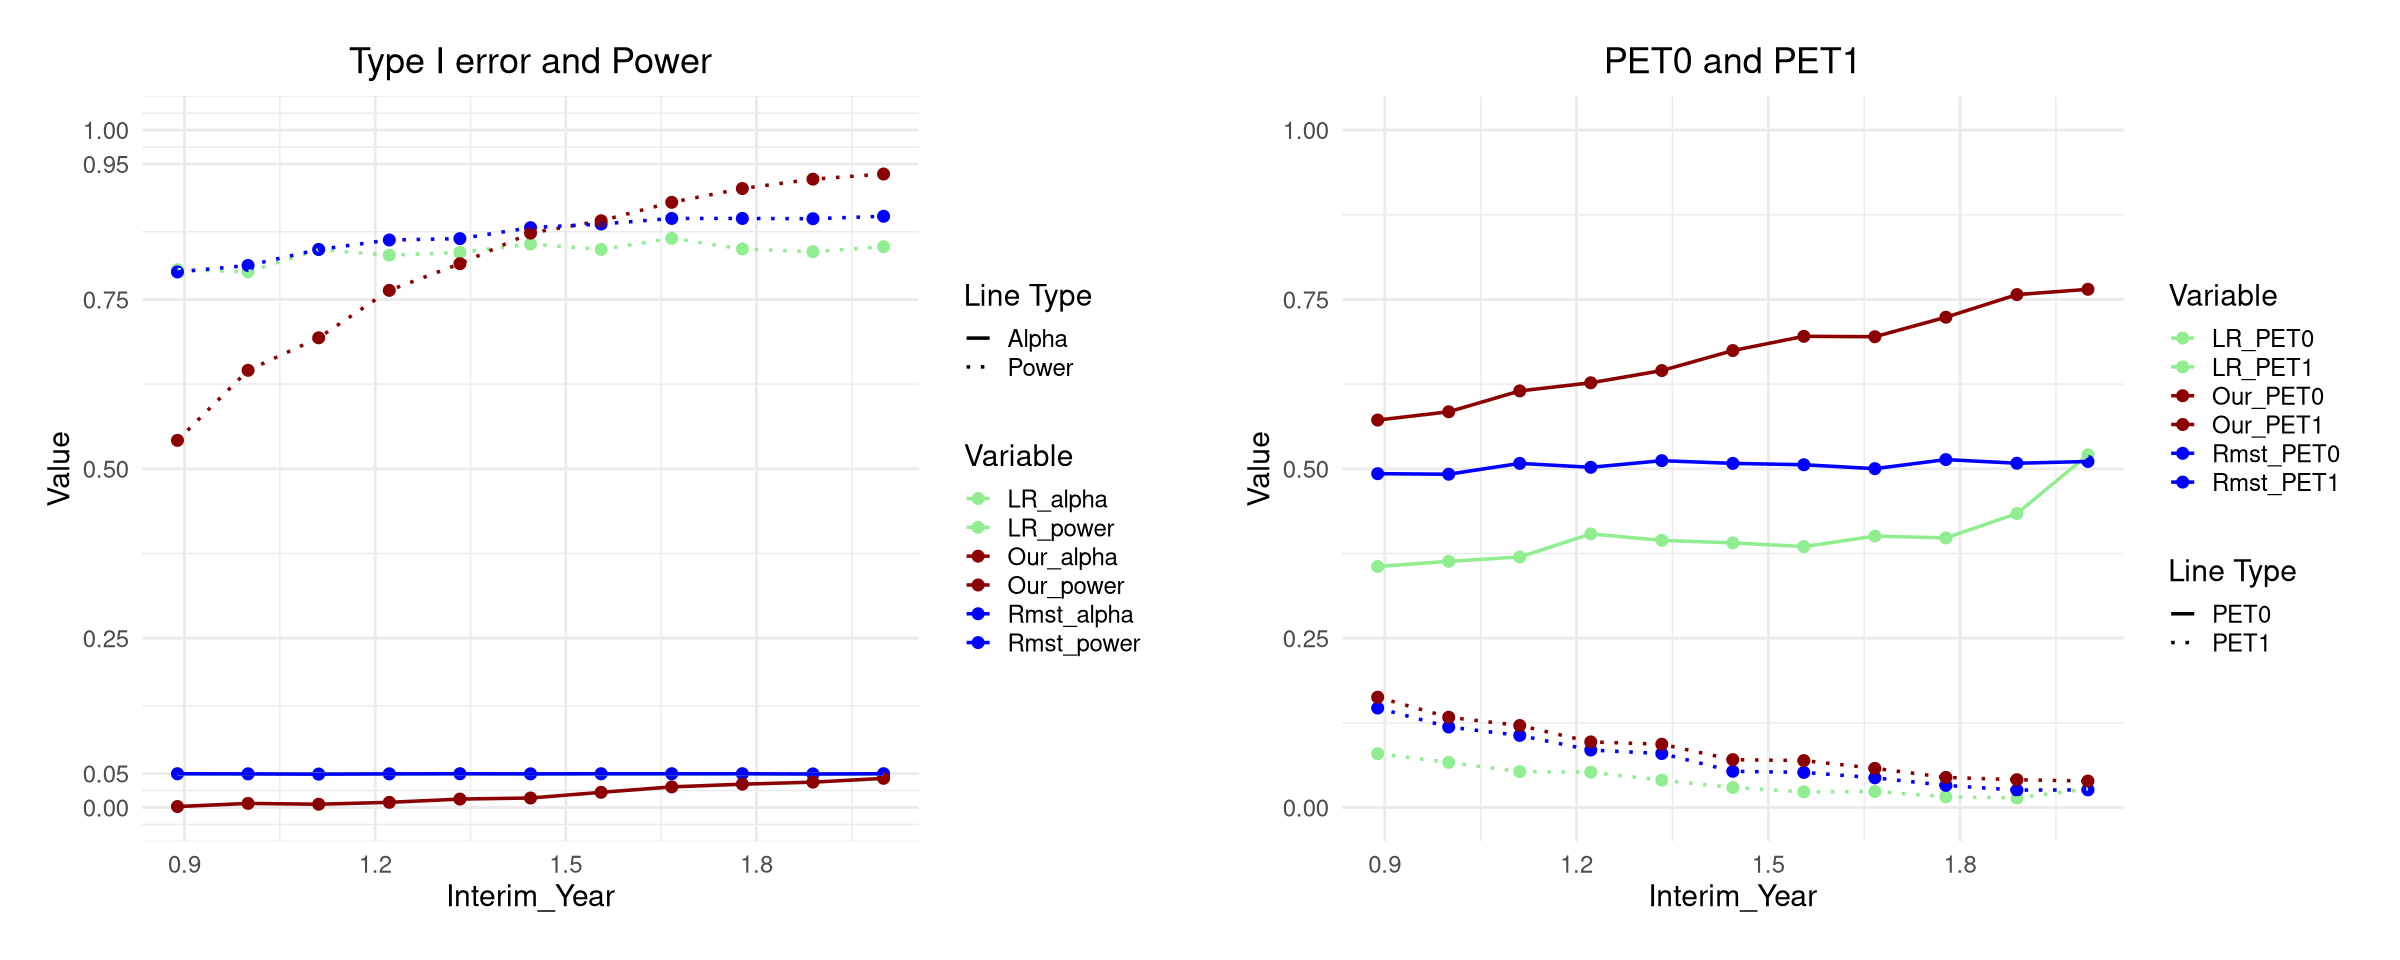

In [26]:
#save(diff_interim, file = '/home/r27user6/RMST_Code/RData/diff_interim.RData')
load('/home/r27user6/RMST_Code/RData/diff_interim.RData')

p3 <- compare_line_plot(data = diff_interim, var_name = 'Interim_Year')
p3

------
## 4. Different Recruit Rate
### Constant recruit rate. Smaller value means longer accrual time and interim period

In [38]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
cen_time <- 1
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
tar_alpha <- 0.05

diff_rec_rate <- foreach(r = seq(40, 130, by = 10), .combine = rbind) %do%
    {
        acc_time <- 200 / r
        interim <- 120 / r 
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(r, result$alpha, result$power, result$PET0, result$PET1)      
    }

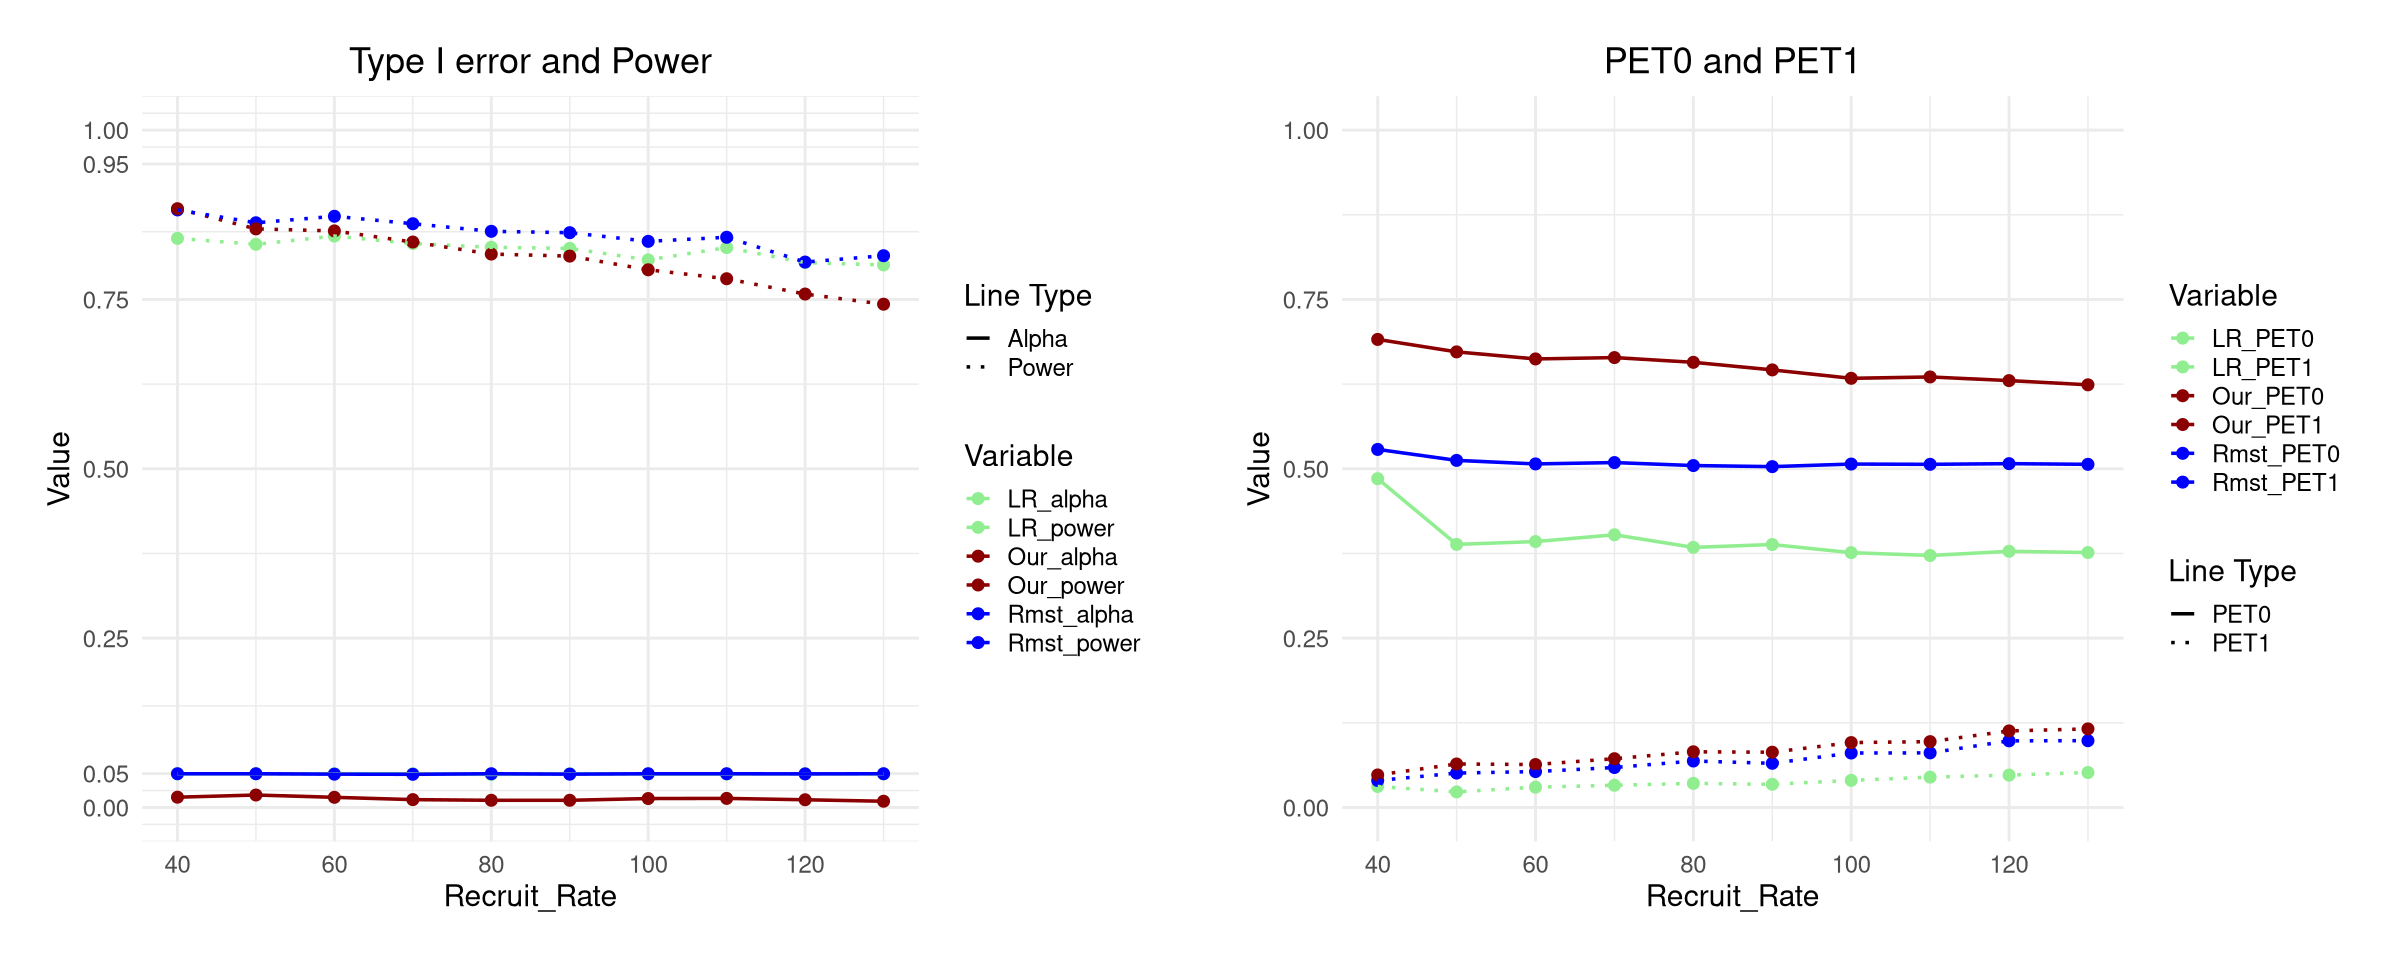

In [27]:
#save(diff_rec_rate, file = '/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')
load('/home/r27user6/RMST_Code/RData/diff_rec_rate.RData')

p4 <- compare_line_plot(data = diff_rec_rate, var_name = 'Recruit_Rate')
p4

-----
## 5. Different Follow Up Time : censoring distribution
### Censoring distribution $C \sim U [b , a + b]$, where b is the follow up time.
### We tune b from 0.6 to 1.6

In [5]:
set.seed(2024)
sim_size <- 5000
n <- ceiling(200 / 2)  # total sample size per arm
r <- 90
acc_time <- 200 / r
interim <- 120 / r
lambda_H1 <- 0.83
delta <- 1.5
lambda_H0 <- lambda_H1 * delta
alpha <- 0.05

diff_cen <- foreach(cen_time = seq(0.6, 1.6, by = 0.1), .combine = rbind) %do%
    {
        result <- m3_compare(n = n, sim_size = sim_size, acc_time = acc_time, cen_time = cen_time, 
                interim = interim, lambda_H0 = lambda_H0, lambda_H1 = lambda_H1, H1_type = 'PH', alpha = alpha)
        c(cen_time, result$alpha, result$power, result$PET0, result$PET1)       
    }

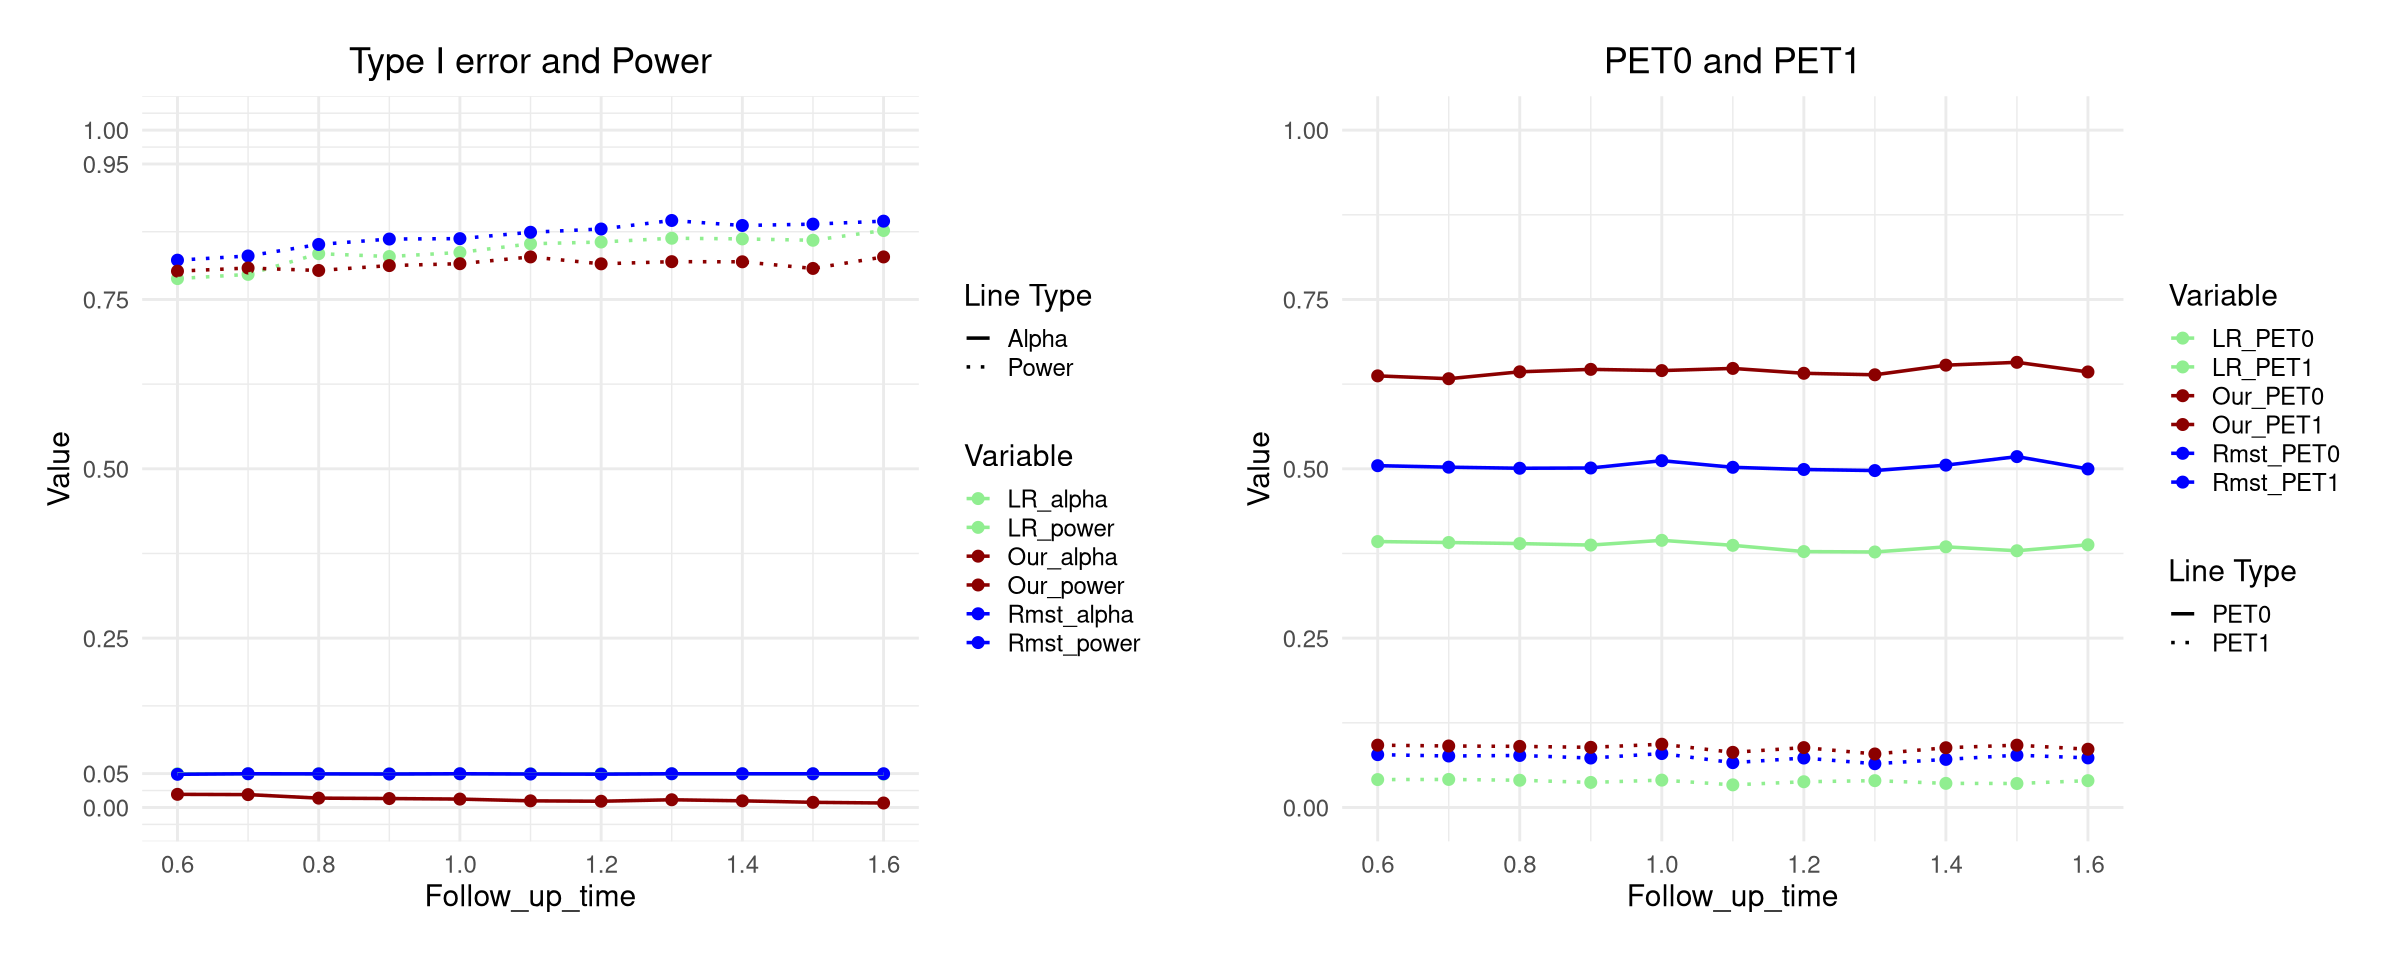

In [28]:
#save(diff_cen, file = '/home/r27user6/RMST_Code/RData/diff_cen.RData')
load('/home/r27user6/RMST_Code/RData/diff_cen.RData')

p5 <- compare_line_plot(data = diff_cen, var_name = 'Follow_up_time')
p5

In [29]:
p <- plot_grid(p1,p2,p3,p4,p5, ncol = 1)
ggsave("figures/Comparison/PH.png", plot = p,width = 20, height = 30, limitsize = FALSE)